# Introduction

## Problem description: A/B testing

---

## Setup

Players (users) are randomly split in two groups:

- group1 - even loginIDs
- group2 - odd loginIDs

We are testing which is the best time / place to show popup to players asking them to allow push notifications:

- group1 - immediately after the installation (before the first tutorial battle)
- group2 - after the tutorial (which consists of 5 battles)

We are optimizing towards:

- Hit rate (% of players who allow push notifications)
- Player Retention

Test was run for two weeks (14 days). Only players that participated in the test appear in the provided data.

## Data

There are two anonimized files:

- `notification_allowed.csv`
- `user_history.csv`

### notification_allowed.csv
Sent after request popup has been shown and player has answered (closing the app defaults to `false` as an answer).

```
login_id = int, starting from 1
time
allowed_notifications = true / false
date_id = int, starting from 0, measuring days since the start of the test
```

### user_history.csv
Generated at the end of each day. It is sent for every active user and for every payer (all time payer). When 21 days pass after the player has logged in for the last time, player no longer appears in this table. This is not true for payers, as they are eligible to appear in this table no matter how long has passed since the last log in.

```
  login_id = int, starting from 1
  registration_date_id = date_id when a player has joined the game
  registration_channel = Paid/Organic
  registration_country = country of origin of the first session
  payer = player has spent money at any time in the past
  dau = daily active player: 0 or 1 in this table
  sessions_count = daily count of sessions
  playtime = daily total playtime
  last_login_day = date_id of the last login, up to this day
  days_active_last_7_days = number of days user was active, including this day
  cohort_size = 1 for all in this table
  elo_rating = elo (trophie count) at the end of the day
  arena_level = arena level at the end of the day
  gold = gold stash at the end of the day
  runes_stash_class1_tier1 = stash of various currencies
  runes_stash_class2_tier1
  runes_stash_class3_tier1
  runes_stash_tier2
  spell_runes_stash
  hero_dust
  item_dust
  gold_gained_total = stats for various currencies
  gold_bought_total
  gold_spent_total
  runes_gained_total_class1_tier1
  runes_gained_total_class2_tier1
  runes_gained_total_class3_tier1
  runes_gained_total_tier_2
  spell_runes_gained_total
  runes_spent_class1_tier1
  runes_spent_class2_tier1
  runes_spent_class3_tier1
  runes_spent_total_tier2
  spell_runes_spent_total
  hero_dust_spent_total
  hero_dust_gained_total
  tokens
  tokens_gained_total
  enter_queue_count = number of times player has entered PvP queue
  battles_played = daily battles played
  battles_won = daily battles won
  battles_played_total = battles played up to this day
  battles_won_total = battles won up to this day
  heroes_unlocked = heroes unlocked up to this day
  heroes_level = hero stats
  hero_shards = hero stats
  minion_upgrades = number of times user has upgraded minions
  free_chests_opened_total = various chest stats
  silver_chests_opened_total
  golden_chests_opened_total
  magical_chests_opened_total
  victory_chests_opened_total
  pvp_event_small_chest_small
  pvp_event_small_chest_medium
  pvp_event_small_chest_large
  pvp_event_big_chest_small
  pvp_event_big_chest_medium
  pvp_event_big_chest_large
  cards_gained_total = various card stats
  minion_cards_gained_common_total
  minion_cards_gained_rare_total
  minion_cards_gained_epic_total
  minion_cards_gained_legendary_total
  spell_cards_gained_common_total
  spell_cards_gained_rare_total
  spell_cards_gained_epic_total
  spell_cards_gained_legendary_total
  campaign_tickets = various campaign stats
  max_campaign_level
  equipment_bonus
  campaign_battles
  campaign_battles_total
  event_battles = various live event stats
  event_battles_total
  event_tokens
  group_points
  lives_spent
  milestone_points
  date_id = int, starting from 0, measuring days since the start of the test
```


## Import libraries

In [62]:
# Basic libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.tree import plot_tree

import random
from pathlib import Path

import scipy.stats as stats
from scipy.stats import chi2_contingency


## Util functions

In [24]:
def na_percentage(df):
  missing_percentage = df.isna().sum() / df.shape[0] * 100
  missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
  print(missing_percentage_sorted)

## Load data

In [48]:
file_path_notification = "/Users/mipopovic/Desktop/A_B_testing/data/notification_allowed.csv"
df_not = pd.read_csv(file_path_notification)
df_not.shape

(3859, 4)

In [49]:
df.head()

,login_id,time,allowed_notifications,date_id,group
0,352,999,True,0,1
1,184,2780,True,0,1
2,162,2928,False,0,1
3,130,3689,True,0,1
4,124,4547,True,0,1


In [50]:
file_path_user_history = "/Users/mipopovic/Desktop/A_B_testing/data/user_history.csv"
df_us = pd.read_csv(file_path_user_history)
df_us.shape

(122459, 79)

In [51]:
df_us.head()

,login_id,registration_date_id,registration_channel,registration_country,payer,dau,sessions_count,playtime,last_login_day,days_active_last_7_days,...,equipment_bonus,campaign_battles,campaign_battles_total,event_battles,event_battles_total,event_tokens,group_points,lives_spent,milestone_points,date_id
0,1,0,Organic,Canada,False,1,3,1351,0,1,...,0.0,5,5,0,0,15,0,0,0,0
1,2,0,Organic,Brazil,False,1,1,1046,0,1,...,0.0,2,2,0,0,15,0,0,0,0
2,3,0,Organic,Brazil,False,1,7,5854,0,1,...,0.0,8,8,0,0,40,0,0,0,0
3,4,0,Paid,France,False,1,1,772,0,1,...,0.0,1,1,0,0,40,0,0,0,0
4,5,0,Paid,United Kingdom,False,1,1,521,0,1,...,0.0,2,2,0,0,5,0,0,0,0


# EDA

## Checking for missing values

In [65]:
na_percentage(df_not)

login_id                 0.0
time                     0.0
allowed_notifications    0.0
date_id                  0.0
group                    0.0
dtype: float64


In [64]:
na_percentage(df_us)

registration_date_id_reg              0.0
login_id                              0.0
spell_cards_gained_legendary_total    0.0
campaign_tickets                      0.0
max_campaign_level                    0.0
                                     ... 
dau                                   0.0
sessions_count                        0.0
playtime                              0.0
last_login_day                        0.0
days_active_last_7_days               0.0
Length: 82, dtype: float64


## Dropping useless columns

# Statystical Analysis

## Hit Rate Analysis

In [52]:
df_not['group'] = df_not['login_id'].apply(lambda x: 1 if x % 2 == 0 else 2)

In [53]:

# Step 2: Hit rate analysis
hit_rate_summary = df_not.groupby('group')['allowed_notifications'].agg(
    total_responses='count',
    hits='sum'
).reset_index()

hit_rate_summary['hit_rate'] = hit_rate_summary['hits'] / hit_rate_summary['total_responses']

print(hit_rate_summary)


   group  total_responses  hits  hit_rate
0      1             2487  1434  0.576598
1      2             1372   861  0.627551


In [55]:

# Optional: z-test for proportions
from statsmodels.stats.proportion import proportions_ztest

counts = hit_rate_summary['hits'].values
nobs = hit_rate_summary['total_responses'].values
stat, pval = proportions_ztest(count=counts, nobs=nobs)
print(f"Z-test statistic = {stat:.4f}, p-value = {pval:.4f}")

Z-test statistic = -3.0861, p-value = 0.0020


## Retention Rate

In [59]:

# Prepare user registration date
user_reg_date = df_us[['login_id', 'registration_date_id']].drop_duplicates()
df_us = df_us.merge(user_reg_date, on='login_id', suffixes=('', '_reg'))

# Define retention days
retention_days = [1, 7, 14]
retention_results = []

for day in retention_days:
    target_df = df_us[df_us['date_id'] == df_us['registration_date_id'] + day]
    
    # Filter only users with sufficient observation period
    eligible_users = df_us[df_us['registration_date_id'] + day <= df_us['date_id'].max()]
    eligible_users = eligible_users[['login_id', 'group']].drop_duplicates()
    
    # Get users retained (dau=1) on target day
    retained_users = target_df[target_df['dau'] == 1][['login_id']].drop_duplicates()
    retained_users['retained'] = 1

    # Merge to mark retention
    retention = eligible_users.merge(retained_users, on='login_id', how='left')
    retention['retained'] = retention['retained'].fillna(0)

    summary = retention.groupby('group')['retained'].agg(
        retained='sum',
        total='count'
    ).reset_index()
    summary['retention_rate'] = summary['retained'] / summary['total']
    summary['day'] = day
    retention_results.append(summary)

retention_df = pd.concat(retention_results)


In [60]:

# Chi-squared tests
chi_results = []
for day in retention_days:
    sub = retention_df[retention_df['day'] == day]
    retained = sub['retained'].values
    total = sub['total'].values
    contingency = [
        [retained[0], total[0] - retained[0]],
        [retained[1], total[1] - retained[1]]
    ]
    chi2, p, _, _ = chi2_contingency(contingency)
    chi_results.append({'day': day, 'chi2_stat': chi2, 'p_value': p})

chi_df = pd.DataFrame(chi_results)
retention_df = retention_df.merge(chi_df, on='day')
print(retention_df)

   group  retained  total  retention_rate  day  chi2_stat   p_value
0      1    1058.0   2489        0.425070    1   5.550738  0.018473
1      2    1142.0   2490        0.458635    1   5.550738  0.018473
2      1     596.0   2489        0.239454    7   0.896692  0.343670
3      2     626.0   2490        0.251406    7   0.896692  0.343670
4      1     447.0   2489        0.179590   14   0.256944  0.612227
5      2     462.0   2490        0.185542   14   0.256944  0.612227


## Check confounders

In [61]:
# Get only one row per user for confounders
df_users = df_us.sort_values("date_id").drop_duplicates("login_id")

# Compare registration_channel
channel_ct = pd.crosstab(df_users['group'], df_users['registration_channel'])
chi2_channel, p_channel, _, _ = chi2_contingency(channel_ct)

# Compare registration_country (use top 10 countries for readability)
top_countries = df_users['registration_country'].value_counts().head(10).index
country_ct = pd.crosstab(
    df_users[df_users['registration_country'].isin(top_countries)]['group'],
    df_users[df_users['registration_country'].isin(top_countries)]['registration_country']
)
chi2_country, p_country, _, _ = chi2_contingency(country_ct)

# Compare payer status
payer_ct = pd.crosstab(df_users['group'], df_users['payer'])
chi2_payer, p_payer, _, _ = chi2_contingency(payer_ct)

print(f"Channel p-value: {p_channel:.4f}")
print(f"Country p-value: {p_country:.4f}")
print(f"Payer p-value: {p_payer:.4f}")

Channel p-value: 0.9659
Country p-value: 0.2520
Payer p-value: 0.9988


## Time Series DAU and Retention Curves

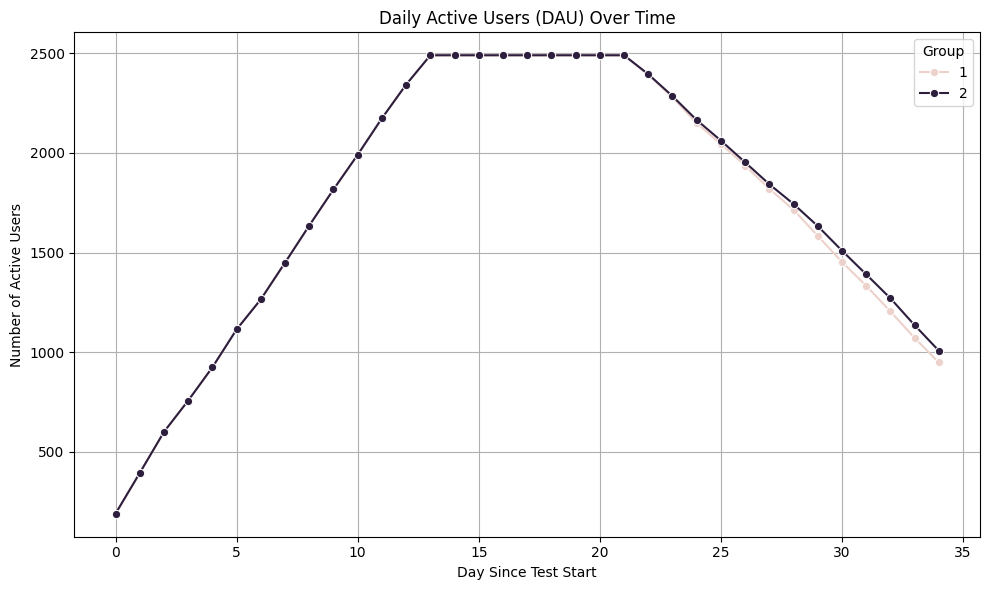

KeyError: 'registration_date_id'

In [63]:

# Make sure group is defined
df_us['group'] = df_us['login_id'].apply(lambda x: 1 if x % 2 == 0 else 2)

# Calculate DAU per group and date
dau_trend = df_us.groupby(['date_id', 'group'])['login_id'].nunique().reset_index()
dau_trend.rename(columns={'login_id': 'dau'}, inplace=True)

# Plot DAU trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=dau_trend, x='date_id', y='dau', hue='group', marker='o')
plt.title("Daily Active Users (DAU) Over Time")
plt.xlabel("Day Since Test Start")
plt.ylabel("Number of Active Users")
plt.legend(title="Group")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Retention curve by cohort
cohort = df_us[['login_id', 'registration_date_id', 'group']].drop_duplicates()
df_ret = df_us[df_us['dau'] == 1]
df_ret = df_ret.merge(cohort, on='login_id')
df_ret['days_since_reg'] = df_ret['date_id'] - df_ret['registration_date_id']

# Keep only first 14 days for the curve
curve_data = df_ret[df_ret['days_since_reg'] <= 14]
retention_curve = curve_data.groupby(['days_since_reg', 'group'])['login_id'].nunique().reset_index()
retention_curve.rename(columns={'login_id': 'retained_users'}, inplace=True)

# Normalize by cohort size
cohort_sizes = cohort.groupby('group')['login_id'].count()
retention_curve['cohort_size'] = retention_curve['group'].map(cohort_sizes)
retention_curve['retention_rate'] = retention_curve['retained_users'] / retention_curve['cohort_size']

# Plot retention curves
plt.figure(figsize=(10, 6))
sns.lineplot(data=retention_curve, x='days_since_reg', y='retention_rate', hue='group', marker='o')
plt.title("Retention Curve by Group (First 14 Days)")
plt.xlabel("Days Since Registration")
plt.ylabel("Retention Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summation and Final Conclusion